<a href="https://colab.research.google.com/github/Nilavan/Self-driving-car/blob/master/Self_driving_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unzip and copy contents to drive

In [ ]:
#!unzip /content/drive/MyDrive/self_driving_data/driving_dataset.zip

In [ ]:
#!cp -av "/content/driving_dataset" "/content/drive/MyDrive/self_driving_data/"

## Sample image from data

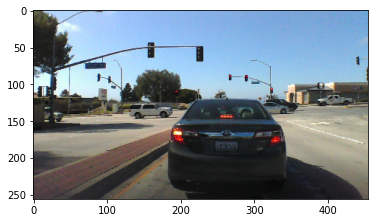

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

img = plt.imread('/content/drive/MyDrive/self_driving_data/driving_dataset/10203.jpg')
plt.imshow(img)
plt.show()

# ~Shuffle data randomly~


In [ ]:
import random

c = list(zip(xs,ys))
random.shuffle(c)
xs,ys = zip(*c)

# Data generator

In [ ]:
import cv2
from tensorflow.keras.utils import Sequence

'''
=============================
x_train = []
y_train = []

x_val = []
y_val = []

for i,id in enumerate(train_xs[:100]):
  img = cv2.imread('/content/drive/MyDrive/self_driving_data/'+str(id))
  img = cv2.resize(img[-150:], (200,66))/255

  x_train.append(img)
  y_train.append(train_ys[i])

for i,id in enumerate(val_xs[:100]):
  img = cv2.imread('/content/drive/MyDrive/self_driving_data/'+str(id))
  img = cv2.resize(img[-150:], (200,66))/255

  x_val.append(img)
  y_val.append(val_ys[i])
=============================
'''

# Reference: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(Sequence):
  'Generates data for Keras'
  def __init__(self, list_IDs, labels, batch_size=32, dim=(66,200,3), shuffle=True):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.labels = labels
    self.list_IDs = list_IDs
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
     indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, *self.dim))
    y = np.empty(self.batch_size)
    
    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      img = cv2.imread('/content/drive/MyDrive/self_driving_data/'+str(ID))
      img = cv2.resize(img[-150:], (200,66))/255
      
      # Store sample
      X[i,] = img
        
      # Store class
      y[i] = float(self.labels[ID])
        
    return X, y

# Get xs and ys from data.txt

In [ ]:
xs = []
ys = []

with open('/content/drive/MyDrive/self_driving_data/driving_dataset/data.txt') as f:
  for line in f:
    xs.append(line.split()[0])
    ys.append(float(line.split()[1]) * 3.14159265 / 180)

num_images = len(xs)
print(xs)

# Train and validation split (TODO)

In [ ]:
'''
=============================
train_xs = xs[:int(len(xs) * 0.8)]
train_ys = ys[:int(len(xs) * 0.8)]

val_xs = xs[-int(len(xs) * 0.2):]
val_ys = ys[-int(len(xs) * 0.2):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)
=============================
'''

partition = {'train':xs[:int(len(xs)*0.8)],'validation':,xs[-int(len(xs) * 0.2):]}
labels = dict(zip(xs,ys))

# Build model

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout
import tensorflow as tf

model = Sequential()

# 5x5 Convolutional layers with stride of 2x2
model.add(Conv2D(24, (5, 5), strides=(2, 2),activation='elu',input_shape=(66,200,3)))
model.add(Conv2D(36, (5, 5), strides=(2, 2),activation='elu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2),activation='elu'))
    
# 3x3 Convolutional layers with stride of 1x1
model.add(Conv2D(64, (3, 3),activation='elu'))
model.add(Conv2D(64, (3, 3),activation='elu'))
    
# Flatten before passing to the fully connected layers
model.add(Flatten())

# Three fully connected layers
model.add(Dense(100,activation='elu'))
model.add(Dropout(.25))
model.add(Dense(50,activation='elu'))
model.add(Dropout(.25))
model.add(Dense(10,activation='elu'))
model.add(Dropout(.25))
    
# Output layer with linear activation 
model.add(Dense(1,activation="linear"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)              

# Train model

In [ ]:
# Parameters for datagen.py
params = {'dim': (66,200,3),
          'batch_size': 32,
          'shuffle': True}

# Generators
training_generator = DataGenerator(partition["train"], labels, **params)
validation_generator = DataGenerator(partition["validation"], labels, **params)

model.compile(optimizer='adam', loss="mse")

#train it for 10 epochs
model.fit_generator(generator=training_generator,
                    epochs=10,   
                    validation_data=validation_generator)    

#save trained model.
model.save("model.h5")

Epoch 1/3
4/4 [==============================] - 2s 297ms/step - loss: 0.6650 - val_loss: 0.3437
Epoch 2/3
4/4 [==============================] - 1s 237ms/step - loss: 0.3513 - val_loss: 0.2940
Epoch 3/3
4/4 [==============================] - 1s 229ms/step - loss: 0.4954 - val_loss: 0.3218
